In [1]:
import pandas as pd
import numpy as np

df_feats = pd.read_csv('reduced_data.csv')
df_labels = pd.read_csv('disorders.csv')['Depressed']

df = pd.concat([df_feats, df_labels], axis=1)
df_depr = df.loc[df['Depressed'] == 1].drop(['Depressed'], axis=1, inplace=False)
df_not_depr = df.loc[df['Depressed'] == 0].drop(['Depressed'], axis=1, inplace=False)

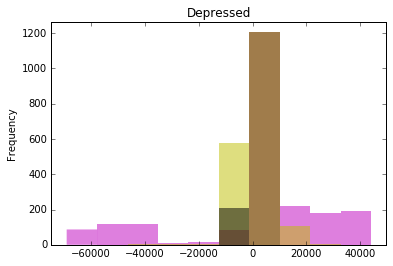

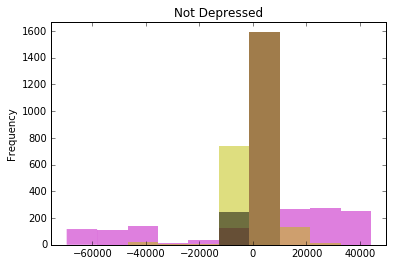

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Have a look at the distribution of Depressed and Not Depressed features
df_depr.plot(kind='hist', alpha=0.5, legend=None, title='Depressed')
df_not_depr.plot(kind='hist', alpha=0.5, legend=None, title='Not Depressed')

In [3]:
depr = df_depr.get_values().T
not_depr = df_not_depr.get_values().T

### State assumptions about your data

Let X<sub>D</sub> denote features of depressed people, X<sub>ND</sub> denote features of people that are not depressed. Let μ<sub>D</sub> be the mean of X<sub>D</sub> and μ<sub>ND</sub> be the mean of X<sub>ND</sub>.

Assume the real X<sub>D</sub> and X<sub>ND</sub> are both from a normal distribution.

### Formally define statistical test

The null and alternative hypotheses are:

- H<sub>0</sub>: μ<sub>D</sub> = μ<sub>ND</sub>
- H<sub>A</sub>: μ<sub>D</sub> != μ<sub>ND</sub>

### Provide algorithm for implementing test

We use Kolmogorov-Smirnov Goodness-of-Fit Test, which is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

The original 754 features was reduced to 27 features, and on each of the 27 features, K-S test is applied below.

In [4]:
from scipy.stats import pearsonr
from scipy.stats import chisquare
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp

pearsonr_test = lambda x: pearsonr(x[0], x[1])[1]
chi_test = lambda x: chisquare(x[0], x[1])[1]
ks_test = lambda x: ks_2samp(x[0], x[1])[1]
anderson_ksamp_test = lambda x: anderson_ksamp(x)[2]

#### Note: Generate random samples and plot power vs n on null set based on Greg's code.

### Random Sampling Setup

In [5]:
import itertools

np.random.seed(123456789) # for reproducibility, set random seed
alpha = 0.05 
r = 20  # number of rois
N = 100 # number of samples at each iteration

# define number of subjects per class
S = np.array((4, 6, 8, 10, 14, 18, 20, 26, 30, 40,
              50, 60, 70, 80, 100, 120, 150, 200, 250,
              300, 400, 500, 750, 1000, 1500, 2000,
              3000, 5000))

### Sample data from null

In [6]:
pow_null = np.array((), dtype=np.dtype('float64'))

# compute this statistic for various sizes of datasets
for s in S:
    s0 = s/2
    s1 = s - s0

    # compute this many times for each operating point to get average
    pval = np.array((), dtype=np.dtype('float64'))    
    for _ in itertools.repeat(None,N):
        g0 = 1 * (np.random.rand(r, r, s0) > 0.5) # (null), 0.52 (classes)
        g1 = 1 * (np.random.rand(r, r, s1) > 0.5) # (null), 0.48 (classes)

        # compute feature of data
        pbar0 = 1.0*np.sum(g0, axis=(0,1))/(r**2 * s0)
        pbar1 = 1.0*np.sum(g1, axis=(0,1))/(r**2 * s1)

        # compute K-S test on feature
        pval = np.append(pval, ks_2samp(pbar0, pbar1)[1])
    
    # record average p value at operating point
    pow_null = np.append(pow_null, np.sum(1.0*(pval < alpha))/N)

### Sample data from alternate

In [7]:
pow_alt = np.array((), dtype=np.dtype('float64'))

# compute this statistic for various sizes of datasets
for s in S:
    s0 = s/2
    s1 = s - s0

    # compute this many times for each operating point to get average
    pval = np.array((), dtype=np.dtype('float64'))    
    for _ in itertools.repeat(None,N):
        g0 = 1 * (np.random.rand(r, r, s0) > 0.52) # (null), 0.52 (classes)
        g1 = 1 * (np.random.rand(r, r, s1) > 0.48) # (null), 0.48 (classes)

        # compute feature of data
        pbar0 = 1.0*np.sum(g0, axis=(0,1))/(r**2 * s0)
        pbar1 = 1.0*np.sum(g1, axis=(0,1))/(r**2 * s0)

        # compute K-S test on feature
        pval = np.append(pval, ks_2samp(pbar0, pbar1)[1])
    
    # record average p value at operating point
    pow_alt = np.append(pow_alt, np.sum(1.0*(pval < alpha))/N)

### Plot power vs n on null set

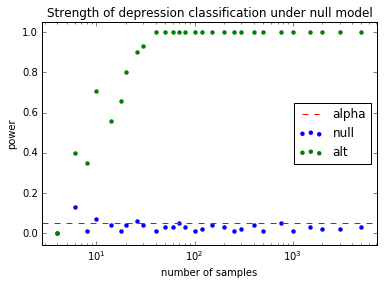

In [8]:
plt.scatter(S, pow_null, hold=True, label='null')
plt.scatter(S, pow_alt, color='green', hold=True, label='alt')
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('power')
plt.title('Strength of depression classification under null model')
plt.axhline(alpha, color='red', linestyle='--', label='alpha')
plt.legend(loc=5)
plt.show()

### Compute p-value on your real data


In [8]:
p_vals = list()
for a, b in zip(depr, not_depr):
    p_vals.append(round(ks_2samp(a, b)[1], 5))
print p_vals

[0.0, 3e-05, 0.99957, 0.04338, 0.08634, 0.70096, 0.18738, 0.0, 0.99991, 0.02431, 0.0, 0.0, 0.42373, 0.0, 0.0, 0.0003, 0.06074, 0.0, 0.0, 0.00034, 0.0, 0.07464, 0.28323, 0.0441, 0.23293, 0.60365, 0.00489]


### Sample from real data and plot power

In [9]:
from skbio.stats.power import subsample_power

# Computer power of a sub sample set
def compute_sub_power(test, samples):
    pwr, counts = subsample_power(test=test,
                                   samples=samples,
                                   max_counts=1205,
                                   min_counts=100,
                                   counts_interval=100,
                                   draw_mode="ind",
                                   alpha_pwr=0.05)
    return pwr, counts

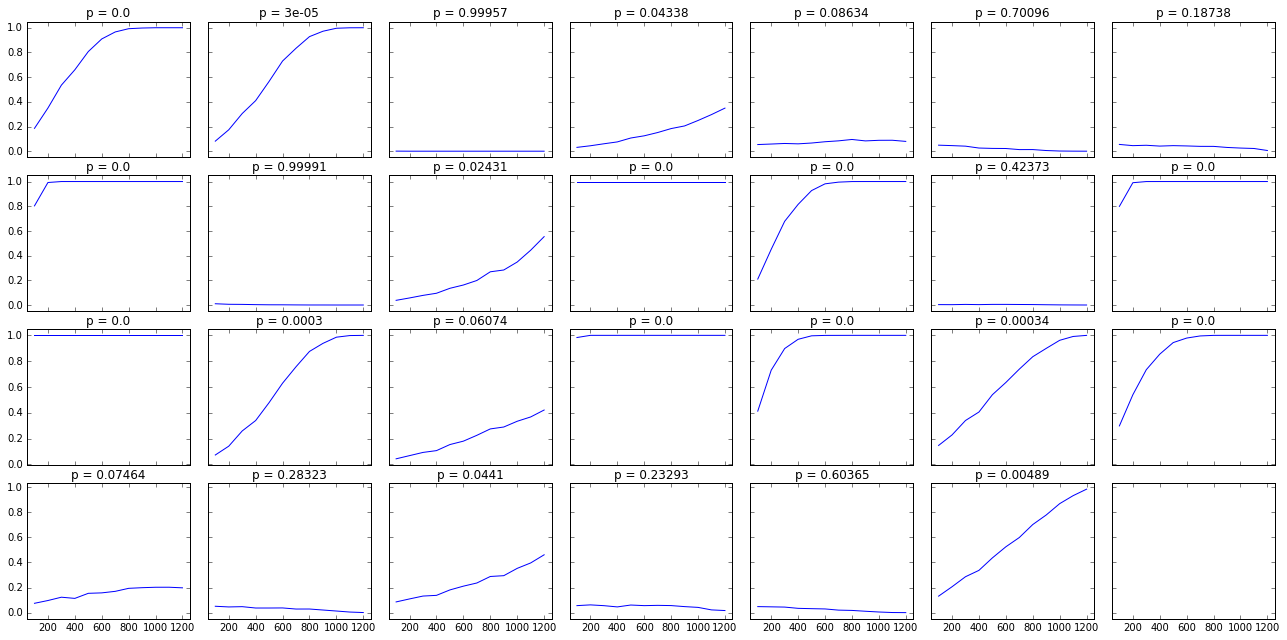

In [10]:
from mpl_toolkits.axes_grid1 import Grid

plt.close('all')
fig = plt.figure()
fig.set_size_inches(18, 9)

grid = Grid(fig, rect=111, nrows_ncols=(4, 7),
            axes_pad=0.25, label_mode='L',
            )
    
def plot_power(i, ax):
    a, b = depr[i], not_depr[i]
    samples = [np.array(a), np.array(b)]
    pwr, counts = compute_sub_power(ks_test, samples) 
    ax.plot(counts, pwr.mean(0))
    
for i, ax in enumerate(grid):
    if i < 27:
        plot_power(i, ax)
        title = 'p = ' + str(p_vals[i])
        ax.set_title(title)

plt.tight_layout()

### Explain the degree to which you believe the result and why

Most (17 out of 27) of the p-values is less than the significance level (0.05), for these we can reject the corresponding null hypotheses. 

The third feature (whose p-value is almost 1.0) is race_id. This makes sense since people of various race are similarly likely to be depressed. The fifth to twenty-seventh features are all sparse-reconstructed and reduced features, it is hard to explain these results intuitively. 

Some of the power curves plotted using real data suspiciously decrease with the increase of number of samples. We know that there exists a lot of zeros in several column and some negative values across the entire feature matrix, since these features are reconstructed, this might be one of the reasons why the power curves act weirdly. 

Also our original data is possibly noisy. We can see that the 10 power curves corresponding to the 10 large p-values (> 0.05) look like power curves of the null distribution, thereby the power curve and the p-value agree with each other on the real data.